# sklearn image classification

## Import Data

In [20]:
import numpy as np
from skimage.io import imread_collection
import os
import matplotlib.pyplot as plt
from dask.array.image import imread


def load_turtles(path, kind='train'):
    f  = os.path.join(path, 'face')
    nf = os.path.join(path, 'noface')
    dir_list = [os.path.join(f, x) for x in os.listdir(f) ]
    nf_dir_list = [os.path.join(nf, x) for x in os.listdir(nf)]
    dir_list=[*dir_list, *nf_dir_list]
    #load all images
    images=imread_collection(dir_list).concatenate()
    
    ##create numpy list of ,matching labels
    face_lb= np.ones(len(os.listdir(f)))
    no_face_lb=np.negative(np.ones(len(os.listdir(nf))))
    labels = np.append(face_lb, no_face_lb)


    return images, labels

data_path = fr'{os.getenv("HOME")}/turtles/data/'
X, y =load_turtles(data_path)

## Splitting the Data to training and testing 

In [21]:
permutation = np.random.permutation(len(X))

X = X[permutation]
y = y[permutation]

m_train = int(len(X)*0.6) #small just for low computers
m_test = len(X) - m_train

X_train, X_test = X[:m_train], X[m_train:]
y_train, y_test = y[:m_train], y[m_train:]
print(m_train, m_test, m_train+m_test)

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

2398 1600 3998
Labels in training dataset:  [-1.  1.]
Frequencies in training dataset:  [1180 1218]


### Functions to change from rgb to 2D greyscale for Sklearn

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

## Data Plotting Functions 

In [23]:
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index],
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])

def plot_col_and_grey(X_matrix, X_grey, labels, index):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    ax[0].imshow(X_matrix[index], cmap = plt.cm.gray_r, interpolation = "nearest")
    ax[1].imshow(X_grey[index], cmap = plt.cm.gray_r, interpolation = "nearest")
    print("LABEL: %i"%labels[index]) 

## Convert The Data  

LABEL: -1


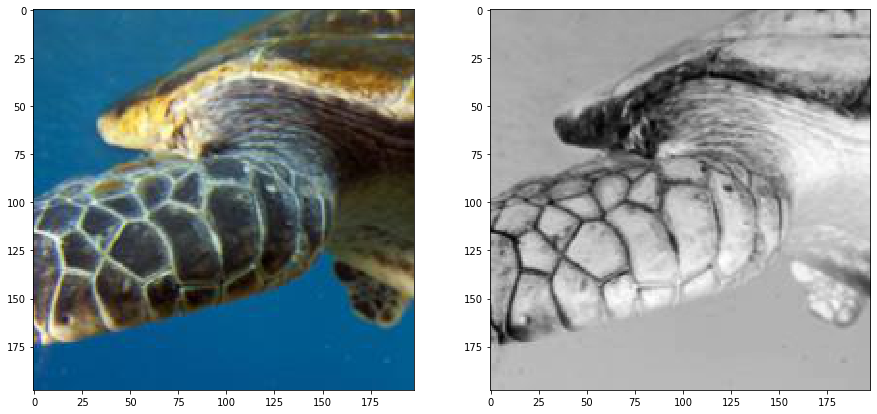

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import hog
import skimage

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
X_train_gray_t = X_train_gray

plot_col_and_grey(X_train, X_train_gray, y_train, 200)

In [28]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [29]:
np.shape(X_train_prepared)

(2398, 6084)

In [33]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [34]:
y_pred = sgd_clf.predict(X_test_prepared)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  99.4375


### Examine incorrect

LABEL: 1
LABEL: 1
LABEL: 1
LABEL: -1
LABEL: 1
LABEL: -1
LABEL: 1
LABEL: -1
LABEL: 1


[None, None, None, None, None, None, None, None, None]

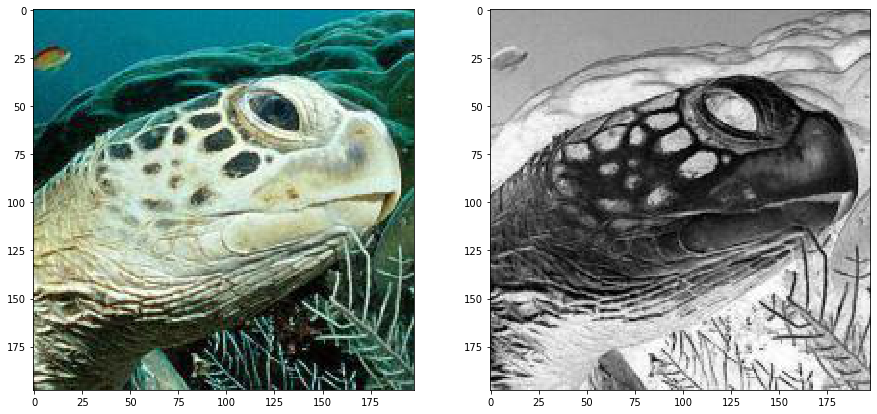

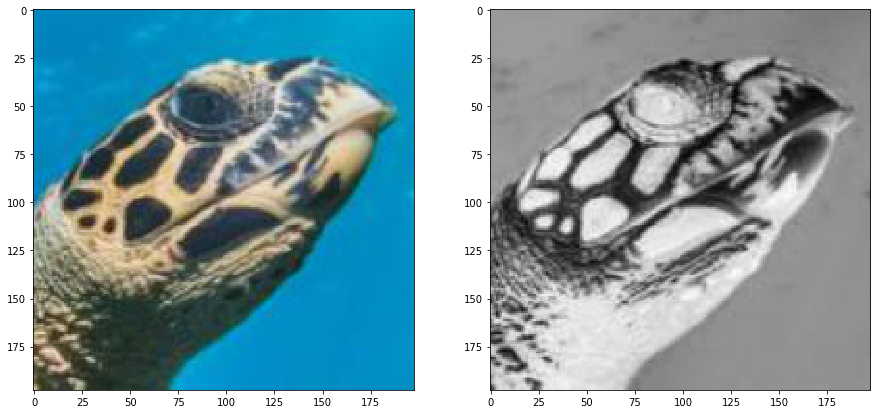

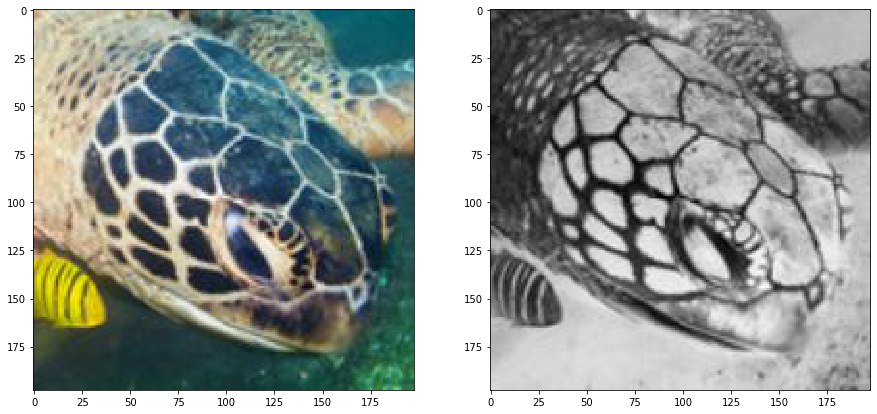

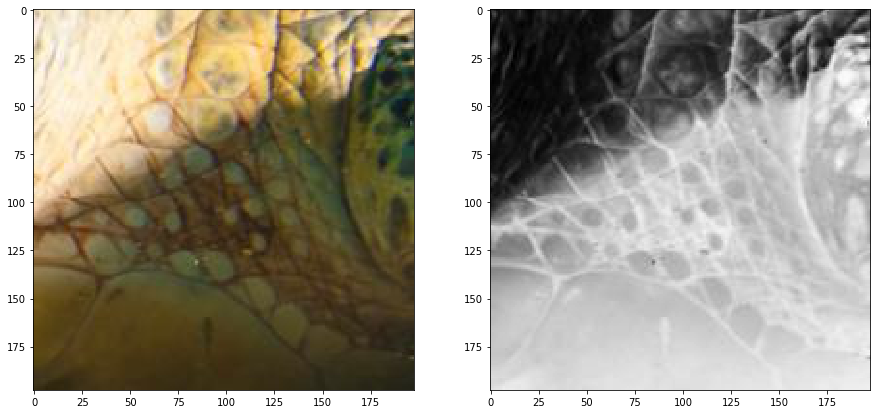

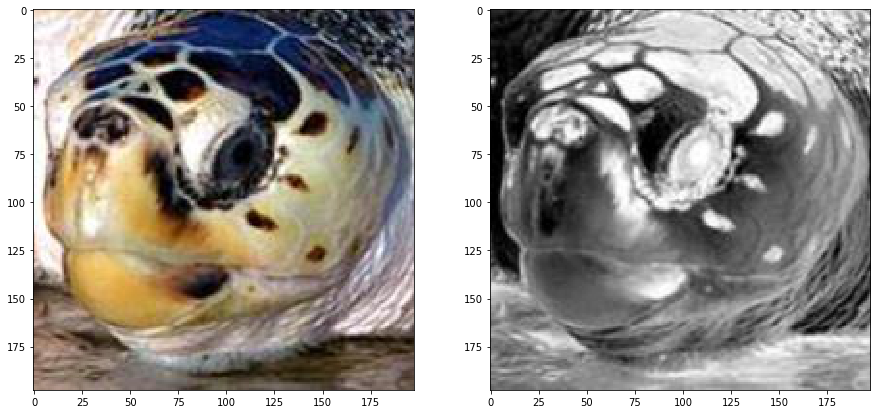

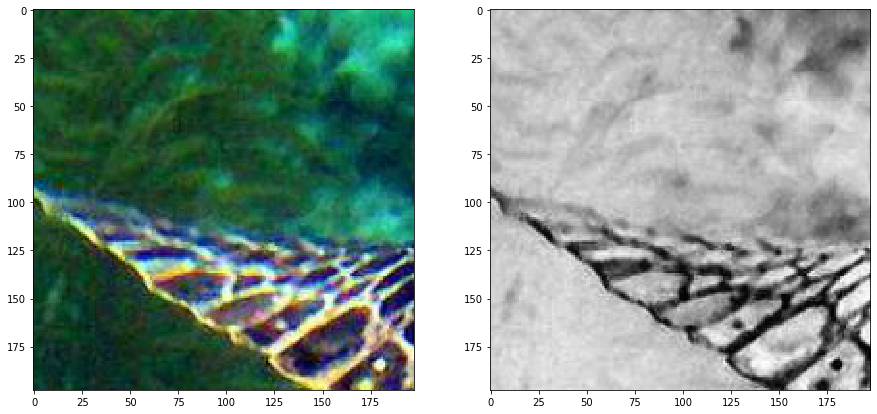

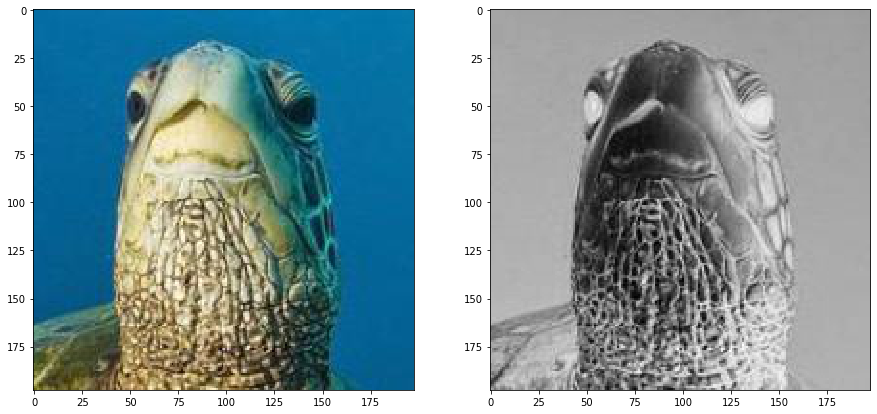

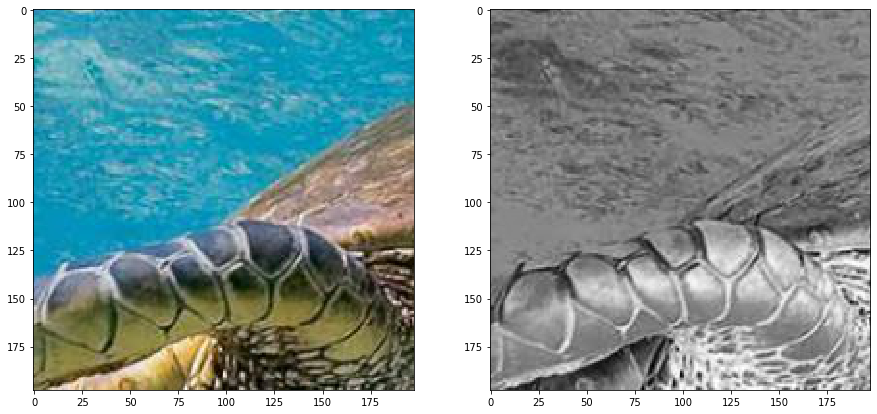

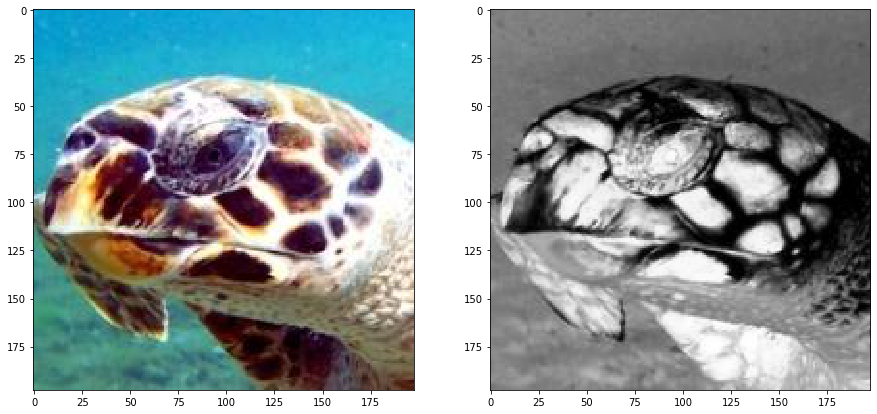

In [35]:
fails=X_test[y_pred!=y_test]
fails_grey = X_test_gray[y_pred!=y_test]
[plot_col_and_grey(X_train, X_train_gray, y_train, x) for x in range(0, len(fails))]

In [ ]:
import numpy as np
from skimage.io import imread_collection
import os
import matplotlib.pyplot as plt

def load_turtles(path, kind='train'):
    f  = os.path.join(path, 'face')
    nf = os.path.join(path, 'noface')
    dir_list = [os.path.join(f, x) for x in os.listdir(f) ]
    nf_dir_list = [os.path.join(nf, x) for x in os.listdir(nf)]
    dir_list=[*dir_list, *nf_dir_list]
    
    #load all images
    images=imread_collection(dir_list).concatenate()
    
    ##create numpy list of ,matching labels
    face_lb= np.ones(len(os.listdir(f)))
    no_face_lb=np.negative(np.ones(len(os.listdir(nf))))
    labels = np.append(face_lb, no_face_lb)


    return images, labels

data_path = fr'{os.getenv("HOME")}/turtles/data/'
X, y =load_turtles(data_path)